In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install wordcloud
%pip install nltk
%pip install scikit-learn
%pip install mlxtend
%pip install unidecode


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------------- 624.3/624.3 kB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from unidecode import unidecode
from mlxtend.preprocessing import TransactionEncoder


In [2]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('AA_movie_train_data.csv')

In [4]:
df.head()

Title   Genre  \
0                               Windup (2006)   action   
1                               Hitman (2014)   action   
2                       Taken by Force (2010)   action   
3                      Bui doi Cho Lon (2013)   action   
4   Siam Yuth: The Dawn of the Kingdom (2015)   action   

                                         Description  
0   Windup is a very original comedy. We follow B...  
1   Rana and Shuvo, two siblings, are very differ...  
2   When a San Francisco detective goes hunting f...  
3   A man name Lam picks up his girlfriend, but i...  
4   Thap and Sin are a homeless musician brothers...

In [6]:
df['Genre'].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

In [5]:
df['Description'][0]

' Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick\'s life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn\'t get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie\'s girlfriend Latrice and roommate Stuart only accentuate Bernie\'s seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie becau

In [6]:
def get_stop_words(stop_file_path, include_spanish=True):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        custom_stopwords.update(spanish_stopwords)
    
    return frozenset(custom_stopwords)

In [7]:
def clean_text(text):
    text = unidecode(text)                     # strip accents
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [8]:
def tokenize_text(text):
    return word_tokenize(text)

In [9]:
def get_wordnet_pos(treebank_tag):
    """Convert TreeBank POS tags to WordNet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


In [10]:
def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  # You already have this function
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas

In [11]:
stopwords = get_stop_words("stopwords.txt", include_spanish=True)

# 🔹 3. Full processing pipeline function
def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)

# 🔹 4. Apply to DataFrame
# Apply function and unpack results
df[['description_tokens', 'description_string']] = df['Description'].apply(
    lambda x: pd.Series(full_text_pipeline(x, stopwords))
)

description_tokens = df['description_tokens'].apply(len)
description_string = df['description_string']
df[['description_string']].to_csv('processed_descriptions.csv', index=False)

In [12]:
average_tokens = description_tokens.mean()
average_tokens

68.1758

In [13]:
description_string[0]

'windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gra

In [14]:
description_string.shape

(5000,)

In [15]:
bow_vectorizer = CountVectorizer(max_df=0.16, max_features=5000)
description_bow_matrix = bow_vectorizer.fit_transform(description_string.tolist())

In [16]:
sum_words = description_bow_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [17]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('woman', 1110),
 ('people', 962),
 ('kill', 945),
 ('try', 903),
 ('own', 900),
 ('father', 886),
 ('girl', 879),
 ('leave', 847),
 ('meet', 824),
 ('help', 798),
 ('home', 762),
 ('mother', 755),
 ('wife', 741),
 ('begin', 713),
 ('start', 696),
 ('death', 673),
 ('brother', 670),
 ('police', 663),
 ('city', 659),
 ('lead', 655)]

In [18]:
print('The lowest frequency words:')
words_freq[-20:] 

The lowest frequency words:


[('translate', 10),
 ('thinker', 10),
 ('suppress', 10),
 ('tango', 10),
 ('rosario', 10),
 ('definition', 10),
 ('epidemic', 10),
 ('mississippi', 10),
 ('uber', 10),
 ('loop', 10),
 ('ruling', 10),
 ('depiction', 10),
 ('mohawk', 10),
 ('fatherhood', 10),
 ('manor', 10),
 ('concentration', 10),
 ('mick', 10),
 ('tibet', 10),
 ('toi', 10),
 ('agatha', 10)]

In [19]:
bow_vectorizer.get_feature_names_out()

array(['aaron', 'aarti', 'abandon', ..., 'zombie', 'zone', 'zorawar'],
      dtype=object)

In [20]:
feature_names=np.array(bow_vectorizer.get_feature_names_out())
len(bow_vectorizer.get_feature_names_out())

5000

In [21]:
pd.DataFrame(description_bow_matrix.toarray())

0     1     2     3     4     5     6     7     8     9     ...  4990  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4995     0     0     0     0     0     0     0     0     0     0  ...     0   
4996     0     0     0     0     0     0     0     0     0     0  ...     0   
4997     0     0     0     0     0     0     0     0     0     0  ...     0   
4998     0     0     0     0     0     0     0     0     0     0  ...     0   
4999     0     0     0     0     0     0     0     0     0     0  ...     0   

      4991  4992  4993  4994  4995  4996  4997  4998  4999  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
4995     0     0     0     0     0     0     0     0     0  
4996     0     0     0     0     0     0     0     0     0  
4997     0     0     0     0     0     0     0     0     0  
4998     0     0     0     0     0     0     0     0     0  
4999     0     0     0     0     0     0     0     0     0  

[5000 rows x 5000 columns]

In [22]:
df_bow = pd.DataFrame(description_bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
df_bow.to_csv('asg1_bow_export.csv', index=False)

### 1.4 TF-IDF

In [23]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
description_tfidf = tfidf_transformer.fit_transform(description_bow_matrix)

In [24]:
tfidf_transformer.idf_

array([7.1194979 , 7.7256337 , 4.68111126, ..., 5.56614945, 6.29851735,
       8.82424599])

In [25]:
tfidf_transformer.idf_.shape

(5000,)

In [26]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['own' 'woman' 'try' 'people' 'meet' 'leave' 'help' 'kill' 'begin' 'start'
 'home' 'father' 'decide' 'lead' 'girl' 'follow' 'force' 'look' 'wife'
 'death' 'set' 'name' 'tell' 'bring' 'mother' 'city' 'soon' 'run' 'fall'
 'call' 'fight' 'child' 'daughter' 'police' 'return' 'change' 'night'
 'brother' 'discover' 'town' 'murder' 'lose' 'local' 'house' 'past'
 'documentary' 'secret' 'learn' 'plan' 'play' 'school' 'move' 'dream'
 'job' 'journey' 'save' 'series' 'money' 'happen' 'struggle'
 'relationship' 'movie' 'include' 'real' 'country' 'escape' 'war' 'hand'
 'head' 'die' 'win' 'character' 'event' 'american' 'attempt' 'realize'
 'break' 'sister' 'boy' 'husband' 'dead' 'student' 'stop' 'bad' 'power'
 'human' 'age' 'team' 'true' 'little' 'question' 'experience' 'former'
 'create' 'search' 'evil' 'believe' 'drug' 'beautiful' 'hold']


In [27]:
pd.DataFrame(description_tfidf.toarray())

0     1     2     3     4     5     6     7     8     9     ...  4990  \
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      4991  4992  4993  4994  4995  4996  4997  4998  4999  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5000 rows x 5000 columns]

In [28]:
# find maximum value for each of the features over dataset:
max_value = description_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['praise' 'pound' 'tease' 'dire' 'endanger' 'obsessive' 'conceal' 'injure'
 'kapoor' 'operate' 'seriously' 'thirsty' 'dc' 'actually' 'flees'
 'resemble' 'enthusiasm' 'flip' 'seventeen' 'verma']
Features with highest tfidf: 
['jo' 'shanichari' 'kishan' 'coral' 'jaggu' 'yoga' 'jaswant' 'devin' 'di'
 'perry' 'volcano' 'pierre' 'sreeram' 'rider' 'selma' 'laundry' 'wine'
 'juan' 'comme' 'mar']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [29]:
idx=0
doc = description_string[idx]
print(doc)

tf_idf_vector=description_tfidf[idx]
print(tf_idf_vector)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [30]:
tf_idf_vector.shape

(1, 5000)

In [31]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

feature_number    tf_idf
0               58  0.032735
1              146  0.033600
2              252  0.047520
3              322  0.172975
4              401  0.042489
..             ...       ...
95            4747  0.041597
96            4889  0.098373
97            4897  0.044398
98            4949  0.065587
99            4952  0.040268

[100 rows x 2 columns]

In [32]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

feature_number    tf_idf
5              430  0.853499
3              322  0.172975
93            4672  0.144446
74            3599  0.103692
88            4288  0.101146
..             ...       ...
52            2572  0.024936
19            1099  0.023812
37            1761  0.022122
39            1895  0.022085
91            4642  0.020175

[100 rows x 2 columns]

In [160]:
topn = 14
results =[]

In [161]:
for idx, doc in description_string.items():
    tf_idf_vector=description_tfidf[idx]
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data), columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    
    results.append(result)

# ❌ MISSING: Add this line
df['keywords'] = results

In [163]:
len(results)

5000

In [164]:
df['keywords'] = results
df.head()

Title   Genre  \
0                               Windup (2006)   action   
1                               Hitman (2014)   action   
2                       Taken by Force (2010)   action   
3                      Bui doi Cho Lon (2013)   action   
4   Siam Yuth: The Dawn of the Kingdom (2015)   action   

                                         Description  \
0   Windup is a very original comedy. We follow B...   
1   Rana and Shuvo, two siblings, are very differ...   
2   When a San Francisco detective goes hunting f...   
3   A man name Lam picks up his girlfriend, but i...   
4   Thap and Sin are a homeless musician brothers...   

                                  description_tokens  \
0  [windup, original, comedy, follow, bernie, sha...   
1  [rana, shuvo, sibling, father, police, constab...   
2  [san, francisco, detective, hunt, cruel, asian...   
3  [name, lam, pick, girlfriend, reveal, girlfrie...   
4  [thap, homeless, musician, brother, village, r...   

                                  description_string  \
0  windup original comedy follow bernie shaddick ...   
1  rana shuvo sibling father police constable dea...   
2  san francisco detective hunt cruel asian crime...   
3  name lam pick girlfriend reveal girlfriend act...   
4  thap homeless musician brother village raid kh...   

                                            keywords  
0  {'bernie': 0.853, 'aunt': 0.173, 'uncle': 0.14...  
1  {'rana': 0.677, 'brother': 0.224, 'crime': 0.1...  
2  {'nelson': 0.542, 'violent': 0.222, 'detective...  
3  {'lam': 0.744, 'gangster': 0.386, 'martial': 0...  
4  {'ram': 0.768, 'prince': 0.34, 'kingdom': 0.23...

In [165]:
# Extract only the keyword keys from the dictionary (ignore TF-IDF values)
token_lists = df['keywords'].apply(lambda x: list(x.keys()))

# Convert to DataFrame, automatically expands lists into columns
transactions_df = pd.DataFrame(token_lists.tolist())

# Save to CSV without index or header
transactions_df.to_csv('transactions.csv', index=False, header=False)


### 2.2 Association Rules Mining on keywords

In [166]:
transactions = pd.read_csv("transactions.csv", header=None)
transactions.head()

0         1          2        3           4          5       6   \
0  bernie      aunt      uncle     real      stuart    welfare   cuban   
1    rana   brother      crime  bravery      extent     police  shower   
2  nelson   violent  detective    asian   francisco     device     san   
3     lam  gangster    martial   artist  girlfriend    brother    kill   
4     ram    prince    kingdom  village        plan  residence    stir   

          7         8        9           10        11          12         13  
0     invent    mentor  product  commercial      pose      estate         co  
1       tall    tackle  promote     villain     arise      assume    sibling  
2  terrorist    center  capture     partner     steal        gang        art  
3    furious     fight     trap      reveal      stab  protection     guilty  
4       raid  villager     meet       frame  homeless    musician  determine

In [167]:
transactions = [list(d.keys()) for d in results]
print(transactions)

[['bernie', 'aunt', 'uncle', 'real', 'stuart', 'welfare', 'cuban', 'invent', 'mentor', 'product', 'commercial', 'pose', 'estate', 'co'], ['rana', 'brother', 'crime', 'bravery', 'extent', 'police', 'shower', 'tall', 'tackle', 'promote', 'villain', 'arise', 'assume', 'sibling'], ['nelson', 'violent', 'detective', 'asian', 'francisco', 'device', 'san', 'terrorist', 'center', 'capture', 'partner', 'steal', 'gang', 'art'], ['lam', 'gangster', 'martial', 'artist', 'girlfriend', 'brother', 'kill', 'furious', 'fight', 'trap', 'reveal', 'stab', 'protection', 'guilty'], ['ram', 'prince', 'kingdom', 'village', 'plan', 'residence', 'stir', 'raid', 'villager', 'meet', 'frame', 'homeless', 'musician', 'determine'], ['ninja', 'diamond', 'smuggler', 'pose', 'assault', 'thug', 'trio', 'rap', 'dealer', 'wood', 'wait', 'beat', 'justice', 'hunt'], ['humanity', 'globe', 'terrorist', 'understand', 'enemy', 'attack', 'turkey', 'bring', 'psyche', 'terrorism', 'topic', 'upcoming', 'global', 'france'], ['munna'

In [168]:
# Assuming df['keywords'] contains dictionaries
transactions = df['keywords'].apply(lambda x: list(x.keys())).tolist()

# Now transactions is a list of lists of strings
te = TransactionEncoder()
data_encoded = te.fit_transform(transactions)

# Convert to DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=te.columns_)

# Check shape
print(data_encoded_df.shape)


(5000, 5000)


In [169]:
# Step 1: Calculate total frequency of each keyword across all transactions
keyword_counts = data_encoded_df.sum().sort_values(ascending=False)

# Step 2: Select top 200 keywords
top_keywords = keyword_counts.head(100).index

# Step 3: Filter the encoded DataFrame to include only these columns
data_encoded_filtered = data_encoded_df[top_keywords]


In [170]:
print(data_encoded.sum(axis=1).mean())

13.9776


In [171]:
data_encoded_filtered.shape

(5000, 100)

In [172]:
data_encoded_filtered

girl  father  brother  mother  woman   kill  school  police   town  \
0     False   False    False   False  False  False   False   False  False   
1     False   False     True   False  False  False   False    True  False   
2     False   False    False   False  False  False   False   False  False   
3     False   False     True   False  False   True   False   False  False   
4     False   False    False   False  False  False   False   False  False   
...     ...     ...      ...     ...    ...    ...     ...     ...    ...   
4995  False   False    False    True  False  False   False   False  False   
4996  False   False    False   False  False  False   False   False  False   
4997  False   False    False   False  False  False   False   False  False   
4998  False   False    False   False  False  False   False   False  False   
4999  False   False    False   False  False  False   False   False  False   

      child  ...  change  criminal  ghost  inspector   look  discover  zombie  \
0     False  ...   False     False  False      False  False     False   False   
1     False  ...   False     False  False      False  False     False   False   
2     False  ...   False     False  False      False  False     False   False   
3     False  ...   False     False  False      False  False     False   False   
4     False  ...   False     False  False      False  False     False   False   
...     ...  ...     ...       ...    ...        ...    ...       ...     ...   
4995  False  ...   False     False  False      False  False     False   False   
4996  False  ...   False     False  False      False  False     False   False   
4997  False  ...   False     False  False      False  False     False   False   
4998  False  ...   False     False  False      False  False     False   False   
4999  False  ...   False     False  False      False  False     False   False   

      officer  music  michael  
0       False  False    False  
1       False  False    False  
2       False  False    False  
3       False  False    False  
4       False  False    False  
...       ...    ...      ...  
4995    False  False    False  
4996    False  False    False  
4997    False  False    False  
4998    False  False    False  
4999    False  False    False  

[5000 rows x 100 columns]

In [173]:
for support in [0.05, 0.01, 0.005, 0.003, 0.002]:
    itemsets = apriori(data_encoded_filtered, min_support=support, use_colnames=True)
    print(f"Support: {support}, Itemsets: {itemsets.shape[0]}")

Support: 0.05, Itemsets: 0
Support: 0.01, Itemsets: 54
Support: 0.005, Itemsets: 100
Support: 0.003, Itemsets: 103
Support: 0.002, Itemsets: 114


In [174]:
frequent_itemsets=apriori(data_encoded_filtered, min_support = 0.002, use_colnames = True)

In [175]:
frequent_itemsets[['support']].describe()

support
count  114.000000
mean     0.011161
std      0.005780
min      0.002000
25%      0.008000
50%      0.009700
75%      0.013550
max      0.028400

In [176]:
frequent_itemsets

support             itemsets
0     0.0284               (girl)
1     0.0280             (father)
2     0.0260            (brother)
3     0.0252             (mother)
4     0.0242              (woman)
..       ...                  ...
109   0.0028  (inspector, police)
110   0.0028    (officer, police)
111   0.0026     (wife, daughter)
112   0.0020      (husband, wife)
113   0.0022        (artist, art)

[114 rows x 2 columns]

In [194]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

antecedents  consequents  antecedent support  consequent support  support  \
0        (girl)     (school)              0.0284              0.0230   0.0022   
1      (school)       (girl)              0.0230              0.0284   0.0022   
2     (brother)     (father)              0.0260              0.0280   0.0024   
3      (father)    (brother)              0.0280              0.0260   0.0024   
4      (mother)     (father)              0.0252              0.0280   0.0032   
5      (father)     (mother)              0.0280              0.0252   0.0032   
6     (brother)     (police)              0.0260              0.0218   0.0022   
7      (police)    (brother)              0.0218              0.0260   0.0022   
8      (mother)   (daughter)              0.0252              0.0186   0.0020   
9    (daughter)     (mother)              0.0186              0.0252   0.0020   
10     (police)       (kill)              0.0218              0.0234   0.0036   
11       (kill)     (police)              0.0234              0.0218   0.0036   
12       (kill)     (killer)              0.0234              0.0134   0.0020   
13     (killer)       (kill)              0.0134              0.0234   0.0020   
14  (inspector)       (kill)              0.0078              0.0234   0.0024   
15       (kill)  (inspector)              0.0234              0.0078   0.0024   
16     (school)    (student)              0.0230              0.0148   0.0034   
17    (student)     (school)              0.0148              0.0230   0.0034   
18  (inspector)     (police)              0.0078              0.0218   0.0028   
19     (police)  (inspector)              0.0218              0.0078   0.0028   
20    (officer)     (police)              0.0076              0.0218   0.0028   
21     (police)    (officer)              0.0218              0.0076   0.0028   
22       (wife)   (daughter)              0.0204              0.0186   0.0026   
23   (daughter)       (wife)              0.0186              0.0204   0.0026   
24    (husband)       (wife)              0.0146              0.0204   0.0020   
25       (wife)    (husband)              0.0204              0.0146   0.0020   
26     (artist)        (art)              0.0092              0.0136   0.0022   
27        (art)     (artist)              0.0136              0.0092   0.0022   

    confidence       lift  representativity  leverage  conviction  \
0     0.077465   3.368034               1.0  0.001547    1.059038   
1     0.095652   3.368034               1.0  0.001547    1.074365   
2     0.092308   3.296703               1.0  0.001672    1.070847   
3     0.085714   3.296703               1.0  0.001672    1.065313   
4     0.126984   4.535147               1.0  0.002494    1.113382   
5     0.114286   4.535147               1.0  0.002494    1.100581   
6     0.084615   3.881440               1.0  0.001633    1.068622   
7     0.100917   3.881440               1.0  0.001633    1.083327   
8     0.079365   4.266940               1.0  0.001531    1.066003   
9     0.107527   4.266940               1.0  0.001531    1.092246   
10    0.165138   7.057163               1.0  0.003090    1.169774   
11    0.153846   7.057163               1.0  0.003090    1.156055   
12    0.085470   6.378365               1.0  0.001686    1.078806   
13    0.149254   6.378365               1.0  0.001686    1.147933   
14    0.307692  13.149244               1.0  0.002217    1.410644   
15    0.102564  13.149244               1.0  0.002217    1.105594   
16    0.147826   9.988249               1.0  0.003060    1.156102   
17    0.229730   9.988249               1.0  0.003060    1.268386   
18    0.358974  16.466714               1.0  0.002630    1.525992   
19    0.128440  16.466714               1.0  0.002630    1.138419   
20    0.368421  16.900048               1.0  0.002634    1.548817   
21    0.128440  16.900048               1.0  0.002634    1.138648   
22    0.127451   6.852203               1.0  0.002221    1.124751  

In [195]:
# Option B
rules_l[ (rules_l['lift'] >= 1.5) &
       (rules_l['confidence'] >= 0.1) ]

antecedents  consequents  antecedent support  consequent support  support  \
4      (mother)     (father)              0.0252              0.0280   0.0032   
5      (father)     (mother)              0.0280              0.0252   0.0032   
7      (police)    (brother)              0.0218              0.0260   0.0022   
9    (daughter)     (mother)              0.0186              0.0252   0.0020   
10     (police)       (kill)              0.0218              0.0234   0.0036   
11       (kill)     (police)              0.0234              0.0218   0.0036   
13     (killer)       (kill)              0.0134              0.0234   0.0020   
14  (inspector)       (kill)              0.0078              0.0234   0.0024   
15       (kill)  (inspector)              0.0234              0.0078   0.0024   
16     (school)    (student)              0.0230              0.0148   0.0034   
17    (student)     (school)              0.0148              0.0230   0.0034   
18  (inspector)     (police)              0.0078              0.0218   0.0028   
19     (police)  (inspector)              0.0218              0.0078   0.0028   
20    (officer)     (police)              0.0076              0.0218   0.0028   
21     (police)    (officer)              0.0218              0.0076   0.0028   
22       (wife)   (daughter)              0.0204              0.0186   0.0026   
23   (daughter)       (wife)              0.0186              0.0204   0.0026   
24    (husband)       (wife)              0.0146              0.0204   0.0020   
26     (artist)        (art)              0.0092              0.0136   0.0022   
27        (art)     (artist)              0.0136              0.0092   0.0022   

    confidence       lift  representativity  leverage  conviction  \
4     0.126984   4.535147               1.0  0.002494    1.113382   
5     0.114286   4.535147               1.0  0.002494    1.100581   
7     0.100917   3.881440               1.0  0.001633    1.083327   
9     0.107527   4.266940               1.0  0.001531    1.092246   
10    0.165138   7.057163               1.0  0.003090    1.169774   
11    0.153846   7.057163               1.0  0.003090    1.156055   
13    0.149254   6.378365               1.0  0.001686    1.147933   
14    0.307692  13.149244               1.0  0.002217    1.410644   
15    0.102564  13.149244               1.0  0.002217    1.105594   
16    0.147826   9.988249               1.0  0.003060    1.156102   
17    0.229730   9.988249               1.0  0.003060    1.268386   
18    0.358974  16.466714               1.0  0.002630    1.525992   
19    0.128440  16.466714               1.0  0.002630    1.138419   
20    0.368421  16.900048               1.0  0.002634    1.548817   
21    0.128440  16.900048               1.0  0.002634    1.138648   
22    0.127451   6.852203               1.0  0.002221    1.124751   
23    0.139785   6.852203               1.0  0.002221    1.138785   
24    0.136986   6.715015               1.0  0.001702    1.135092   
26    0.239130  17.583120               1.0  0.002075    1.296411   
27    0.161765  17.583120               1.0  0.002075    1.182007   

    zhangs_metric   jaccard  certainty  kulczynski  
4        0.799651  0.064000   0.101836    0.120635  
5        0.801955  0.064000   0.091389    0.120635  
7        0.758908  0.048246   0.076917    0.092766  
9        0.780151  0.047847   0.084455    0.093446  
10       0.877428  0.086538   0.145134    0.159492  
11       0.878865  0.086538   0.134989    0.159492  
13       0.854673  0.057471   0.128869    0.117362  
14       0.931213  0.083333   0.291104    0.205128  
15       0.946088  0.083333   0.095509    0.205128  
16       0.921067  0.098837   0.135024    0.188778  
17       0.913401  0.098837   0.211596    0.188778  
18       0.946655  0.104478   0.344689    0.243707  
19       0.960204  0.104478   0.121589    0.243707  
20       0.948034  0.105263   0.354346    0.248431  
21       0.961796  0.105263   0.121766    0.248431  
22  

In [192]:
rules_filtered = rules_l[(rules_l['lift'] > 5) & (rules_l['confidence'] > 0.2)]
rules_filtered

antecedents consequents  antecedent support  consequent support  support  \
14  (inspector)      (kill)              0.0078              0.0234   0.0024   
17    (student)    (school)              0.0148              0.0230   0.0034   
18  (inspector)    (police)              0.0078              0.0218   0.0028   
20    (officer)    (police)              0.0076              0.0218   0.0028   
26     (artist)       (art)              0.0092              0.0136   0.0022   

    confidence       lift  representativity  leverage  conviction  \
14    0.307692  13.149244               1.0  0.002217    1.410644   
17    0.229730   9.988249               1.0  0.003060    1.268386   
18    0.358974  16.466714               1.0  0.002630    1.525992   
20    0.368421  16.900048               1.0  0.002634    1.548817   
26    0.239130  17.583120               1.0  0.002075    1.296411   

    zhangs_metric   jaccard  certainty  kulczynski  
14       0.931213  0.083333   0.291104    0.205128  
17       0.913401  0.098837   0.211596    0.188778  
18       0.946655  0.104478   0.344689    0.243707  
20       0.948034  0.105263   0.354346    0.248431  
26       0.951885  0.106796   0.228640    0.200448

<Axes: >

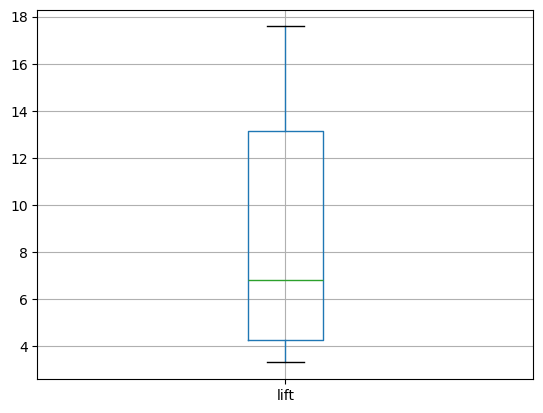

In [193]:
rules_l[['lift']].boxplot()

In [179]:
df

Title     Genre  \
0                                     Windup (2006)     action   
1                                     Hitman (2014)     action   
2                             Taken by Force (2010)     action   
3                            Bui doi Cho Lon (2013)     action   
4         Siam Yuth: The Dawn of the Kingdom (2015)     action   
...                                              ...       ...   
4995                          The Harvesters (2000)   thriller   
4996                                    PRND (2017)   thriller   
4997   Jimmy Tupper vs. the Goatman of Bowie (2010)   thriller   
4998                 Captive of a Death Mask (2012)   thriller   
4999                               Locker 13 (2014)   thriller   

                                            Description  \
0      Windup is a very original comedy. We follow B...   
1      Rana and Shuvo, two siblings, are very differ...   
2      When a San Francisco detective goes hunting f...   
3      A man name Lam picks up his girlfriend, but i...   
4      Thap and Sin are a homeless musician brothers...   
...                                                 ...   
4995   Danielle Carver has inherited the same heart ...   
4996   When Max has a disturbing incident with a dri...   
4997   Jimmy Tupper is a no one, he's nothing. He sp...   
4998   The only one more scared than his victims is ...   
4999   Skip, the nighttime janitor in an Old West th...   

                                     description_tokens  \
0     [windup, original, comedy, follow, bernie, sha...   
1     [rana, shuvo, sibling, father, police, constab...   
2     [san, francisco, detective, hunt, cruel, asian...   
3     [name, lam, pick, girlfriend, reveal, girlfrie...   
4     [thap, homeless, musician, brother, village, r...   
...                                                 ...   
4995  [danielle, carver, inherit, heart, disease, mo...   
4996  [max, disturbing, incident, driver, transporta...   
4997  [jimmy, tupper, spend, day, starbucks, suburba...   
4998  [scar, victim, killer, underground, fighter, p...   
4999  [skip, nighttime, janitor, west, theme, park, ...   

                                     description_string  \
0     windup original comedy follow bernie shaddick ...   
1     rana shuvo sibling father police constable dea...   
2     san francisco detective hunt cruel asian crime...   
3     name lam pick girlfriend reveal girlfriend act...   
4     thap homeless musician brother village raid kh...   
...                                                 ...   
4995  danielle carver inherit heart disease mother d...   
4996  max disturbing incident driver transportation ...   
4997  jimmy tupper spend day starbucks suburban mary...   
4998  scar victim killer underground fighter porter ...   
4999  skip nighttime janitor west theme park delve m...   

                                               keywords  
0     {'bernie': 0.853, 'aunt': 0.173, 'uncle': 0.14...  
1     {'rana': 0.677, 'brother': 0.224, 'crime': 0.1...  
2     {'nelson': 0.542, 'violent': 0.222, 'detective...  
3     {'lam': 0.744, 'gangster': 0.386, 'martial': 0...  
4     {'ram': 0.768, 'prince': 0.34, 'kingdom': 0.23...  
...                                                 ...  
4995  {'danielle': 0.517, 'rachel': 0.448, 'jeff': 0...  
4996  {'max': 0.594, 'driver': 0.364, 'car': 0.204, ...  
4997  {'jimmy': 0.689, 'wood': 0.305, 'monster': 0.2...  
4998  {'victim': 0.264, 'killer': 0.249, 'die': 0.23...  
4999  {'skip': 0.355, 'sage': 0.196, 'play': 0.187, ...  

[5000 rows x 6 columns]

# OTHER METHODS

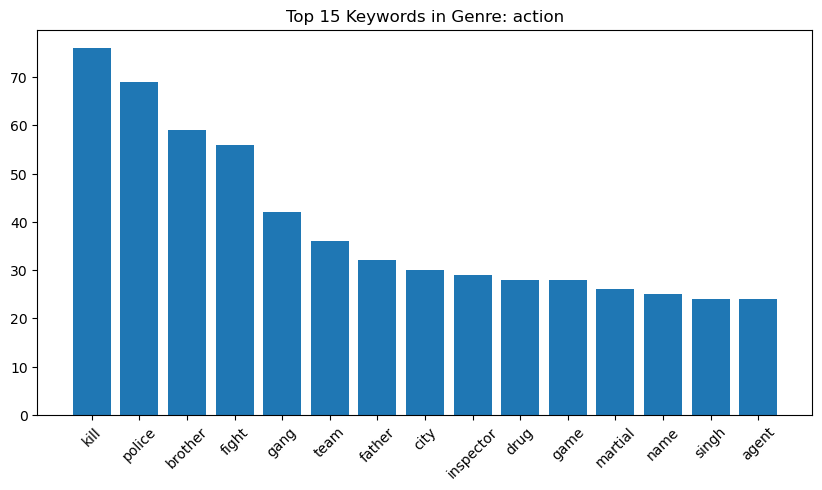

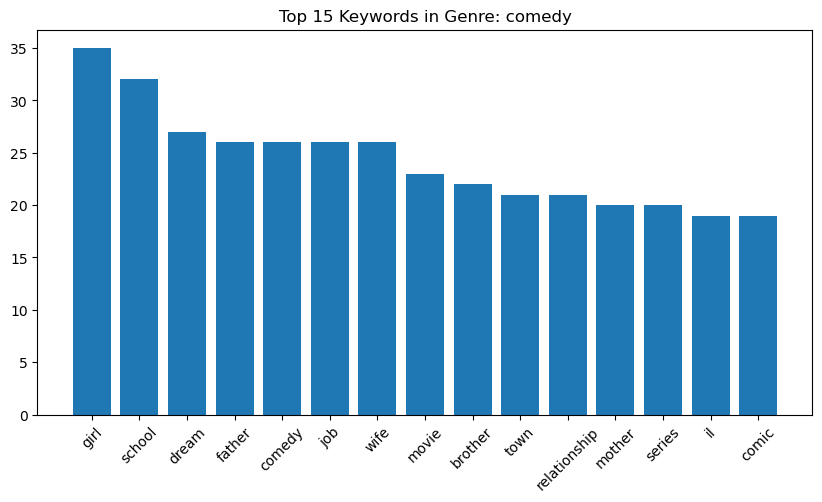

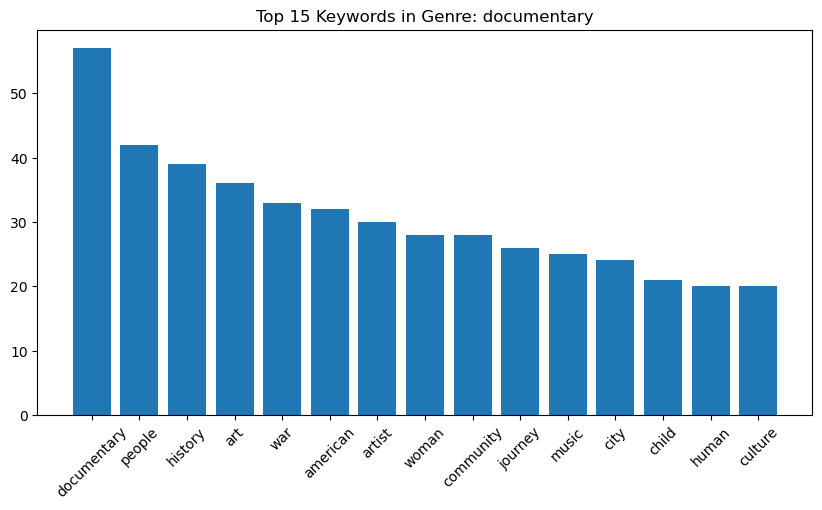

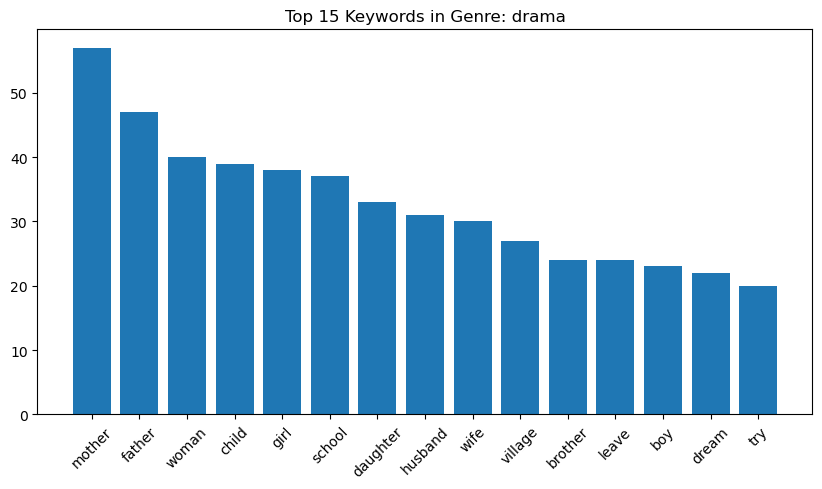

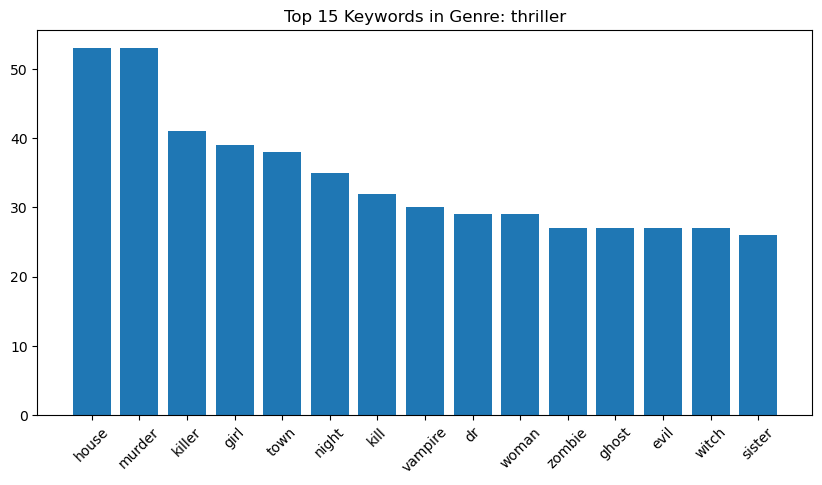

In [196]:
import matplotlib.pyplot as plt
from collections import Counter

# Assume df['keywords'] contains dict of {word: tfidf_score} for each movie
genres = df['Genre'].unique()

for genre in genres:
    # Get all keywords for movies in this genre
    genre_keywords = df[df['Genre'] == genre]['keywords'].tolist()
    
    # Flatten all keywords into a list (ignore tfidf, just use keys)
    all_words = [word for d in genre_keywords for word in d.keys()]
    
    # Count frequency of keywords
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(15)
    
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title(f"Top 15 Keywords in Genre: {genre}")
    plt.xticks(rotation=45)
    plt.show()


In [197]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

genres = df['Genre'].unique()
genre_keywords_sets = {}

# Create a set of unique keywords per genre
for genre in genres:
    all_words = [word for d in df[df['Genre'] == genre]['keywords'].tolist() for word in d.keys()]
    genre_keywords_sets[genre] = set(all_words)

# Compute pairwise Jaccard similarity
for g1 in genres:
    for g2 in genres:
        sim = jaccard_similarity(genre_keywords_sets[g1], genre_keywords_sets[g2])
        print(f"Jaccard similarity between {g1} and {g2}: {sim:.3f}")


Jaccard similarity between action and action: 1.000
Jaccard similarity between action and comedy: 0.717
Jaccard similarity between action and documentary: 0.669
Jaccard similarity between action and drama: 0.724
Jaccard similarity between action and thriller: 0.711
Jaccard similarity between comedy and action: 0.717
Jaccard similarity between comedy and comedy: 1.000
Jaccard similarity between comedy and documentary: 0.708
Jaccard similarity between comedy and drama: 0.775
Jaccard similarity between comedy and thriller: 0.736
Jaccard similarity between documentary and action: 0.669
Jaccard similarity between documentary and comedy: 0.708
Jaccard similarity between documentary and documentary: 1.000
Jaccard similarity between documentary and drama: 0.724
Jaccard similarity between documentary and thriller: 0.680
Jaccard similarity between drama and action: 0.724
Jaccard similarity between drama and comedy: 0.775
Jaccard similarity between drama and documentary: 0.724
Jaccard similarity 

In [204]:
from textblob import TextBlob

# Compute sentiment polarity for each movie's keywords
def keywords_sentiment(keywords_dict):
    text = ' '.join(keywords_dict.keys())
    return TextBlob(text).sentiment.polarity

df['keywords_sentiment'] = df['keywords'].apply(keywords_sentiment)

# Average sentiment per genre
genre_sentiment = df.groupby('Genre')['keywords_sentiment'].mean()
print(genre_sentiment)


Genre
action        -0.005260
comedy         0.033835
documentary    0.087571
drama          0.014349
thriller      -0.074995
Name: keywords_sentiment, dtype: float64


In [205]:
def keywords_sentiment_subjectivity(keywords_dict):
    text = ' '.join(keywords_dict.keys())
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

df[['keywords_polarity', 'keywords_subjectivity']] = df['keywords'].apply(keywords_sentiment_subjectivity)

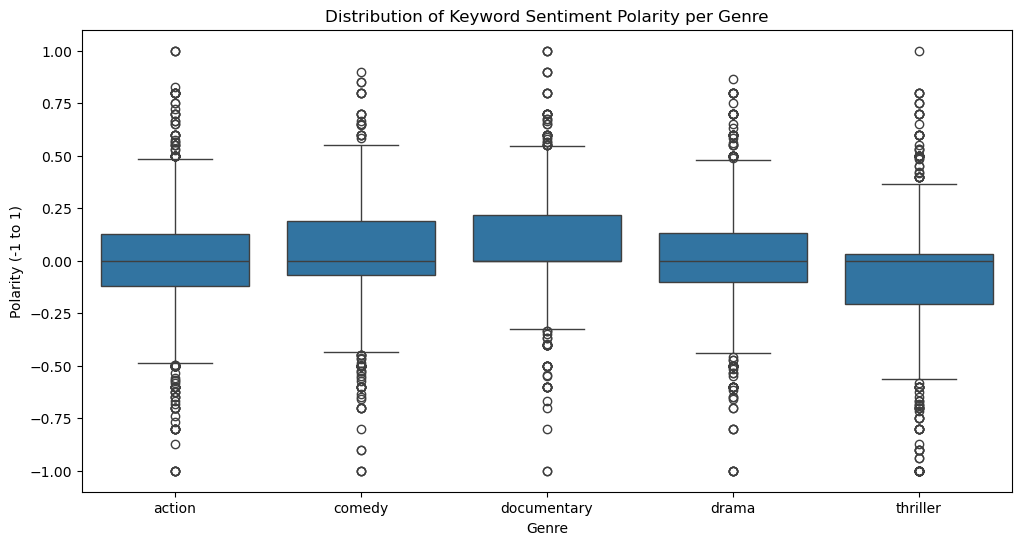

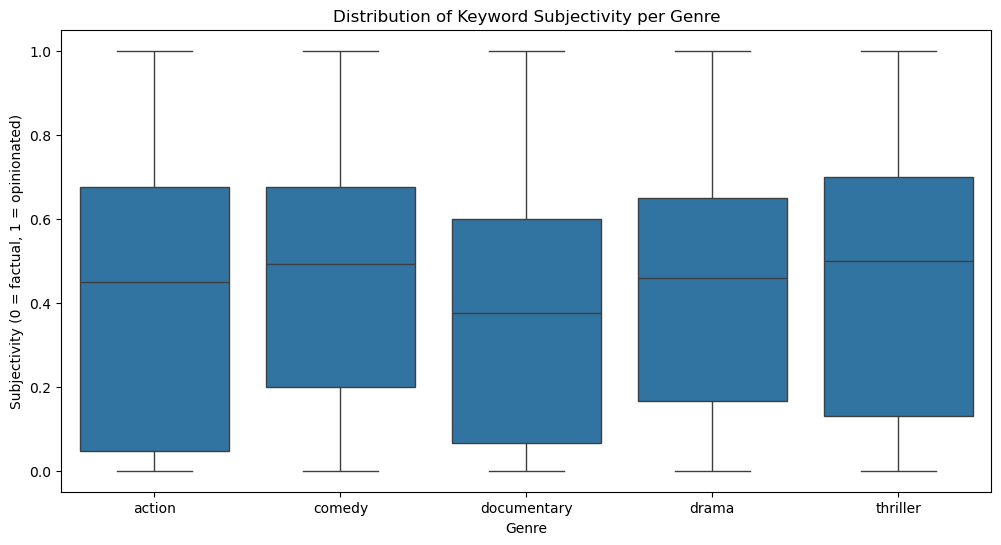

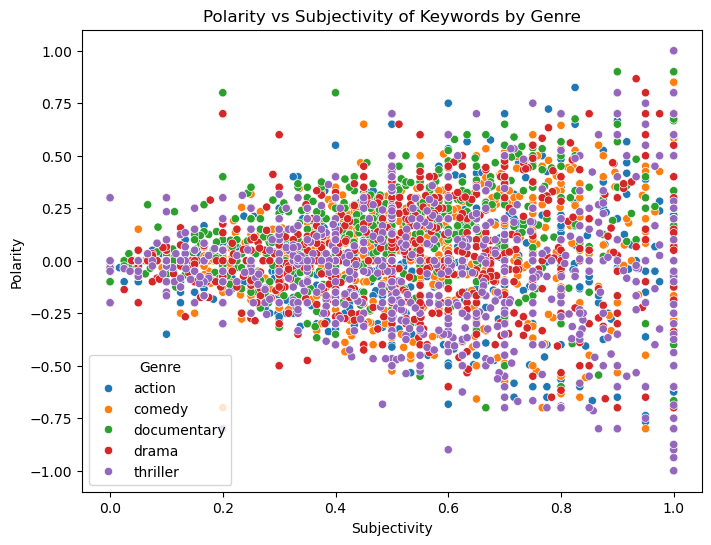

In [206]:
# 2. Plot distribution of polarity per genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='keywords_polarity', data=df)
plt.title('Distribution of Keyword Sentiment Polarity per Genre')
plt.xlabel('Genre')
plt.ylabel('Polarity (-1 to 1)')
plt.show()

# 3. Plot distribution of subjectivity per genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='keywords_subjectivity', data=df)
plt.title('Distribution of Keyword Subjectivity per Genre')
plt.xlabel('Genre')
plt.ylabel('Subjectivity (0 = factual, 1 = opinionated)')
plt.show()

# 4. Optionally, correlation between polarity and subjectivity
plt.figure(figsize=(8,6))
sns.scatterplot(x='keywords_subjectivity', y='keywords_polarity', hue='Genre', data=df)
plt.title('Polarity vs Subjectivity of Keywords by Genre')
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.show()

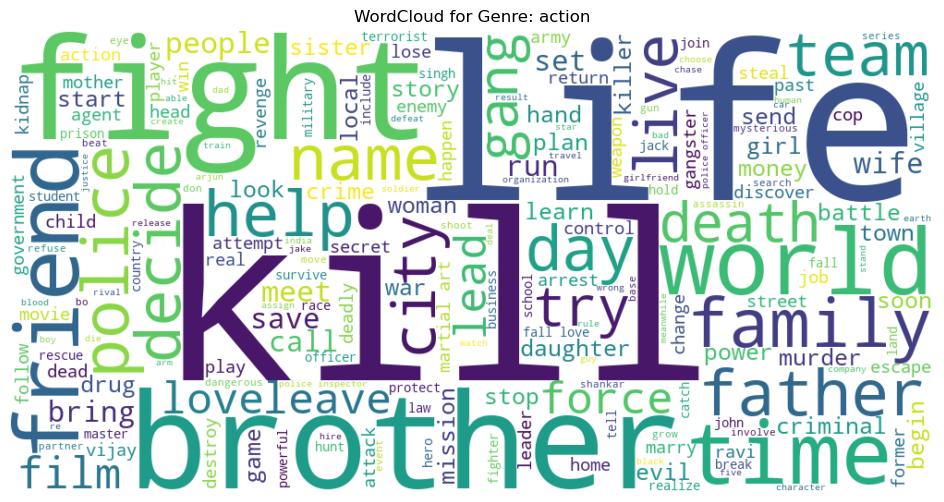

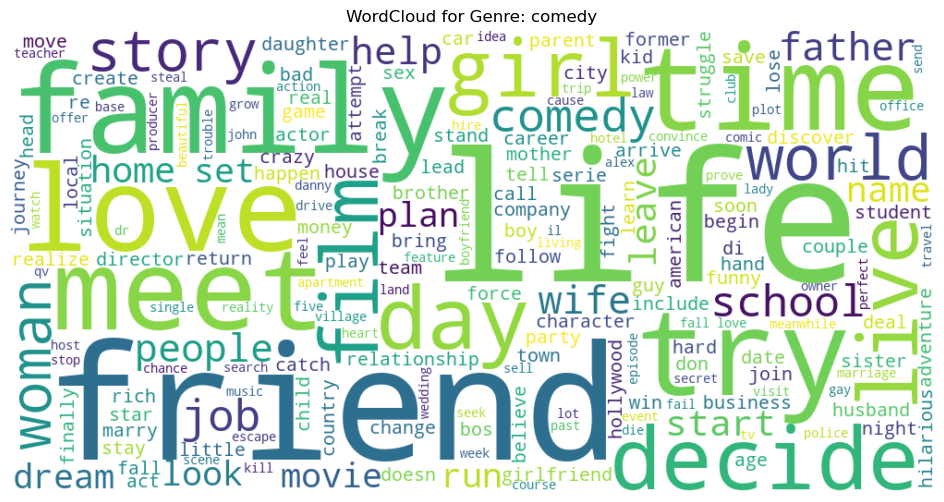

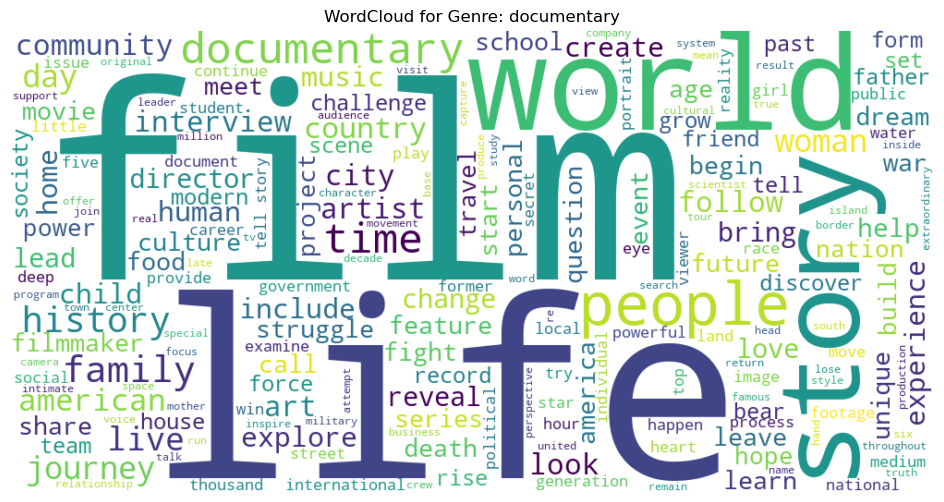

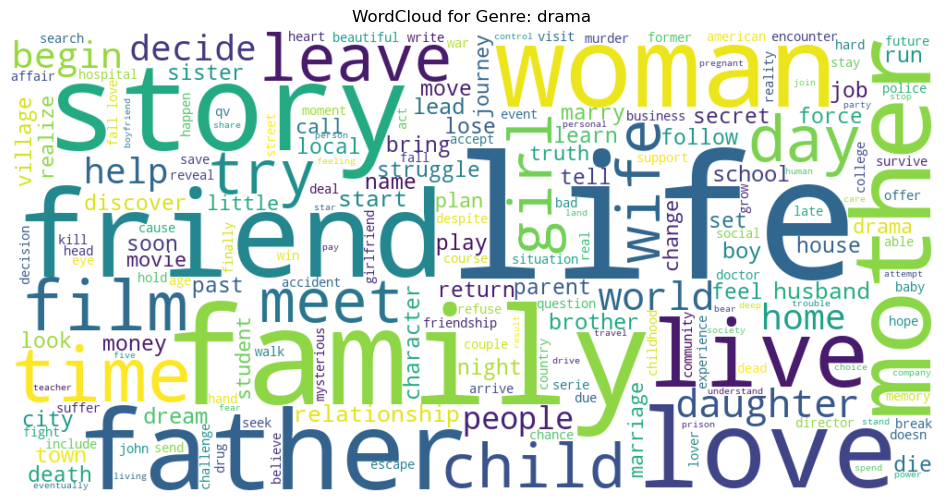

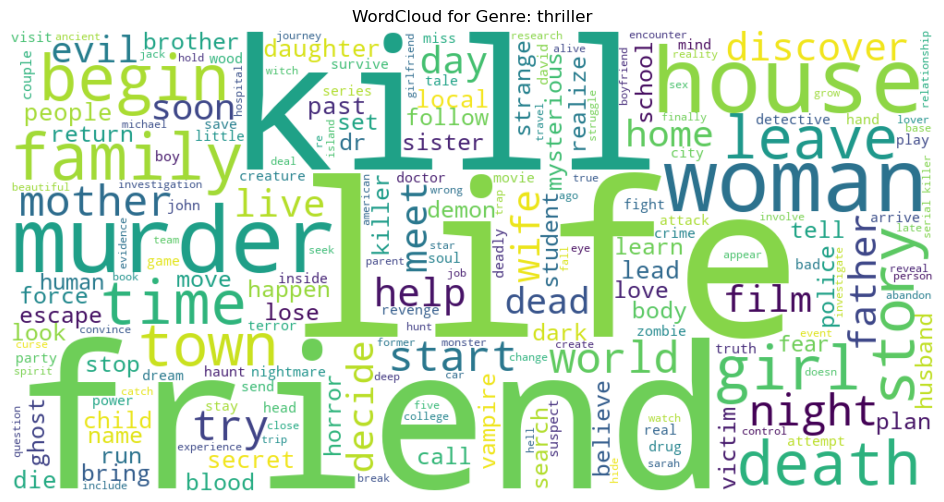

In [180]:
genres = df['Genre'].unique()

for genre in genres:
    text = ' '.join(df[df['Genre'] == genre]['description_string'])
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Genre: {genre}')
    plt.show()


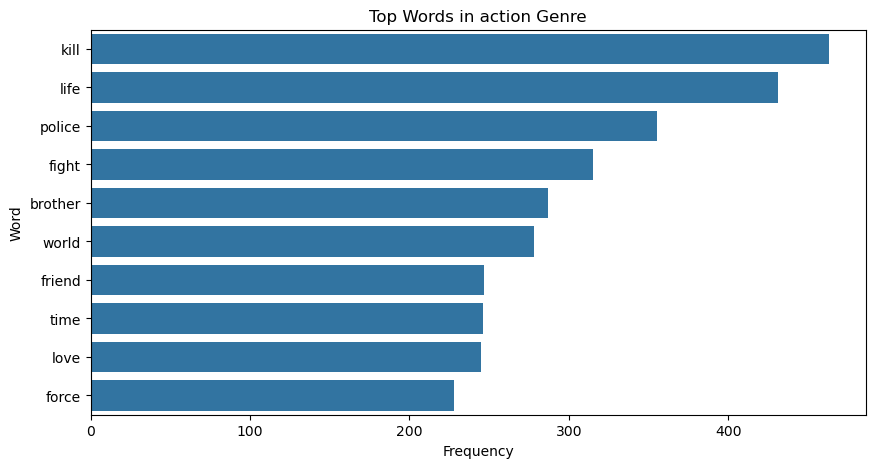

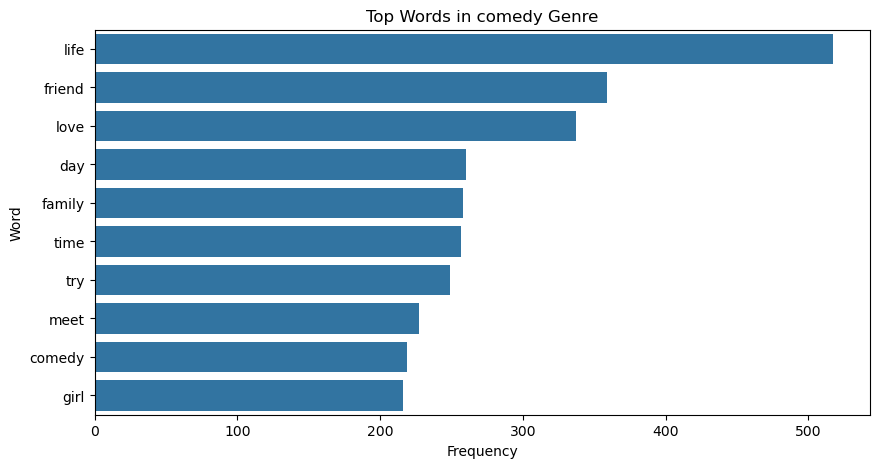

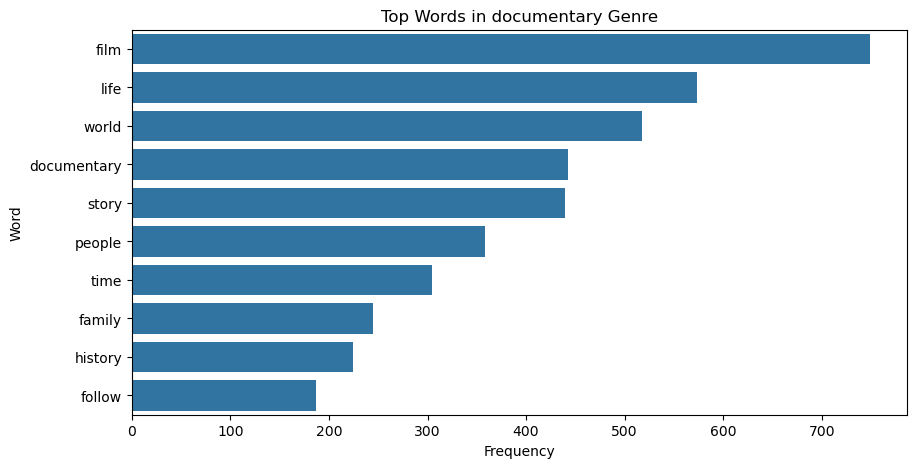

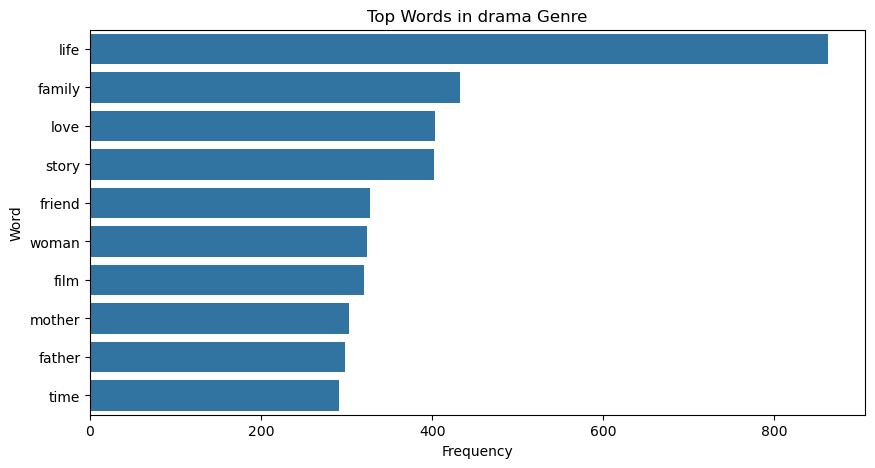

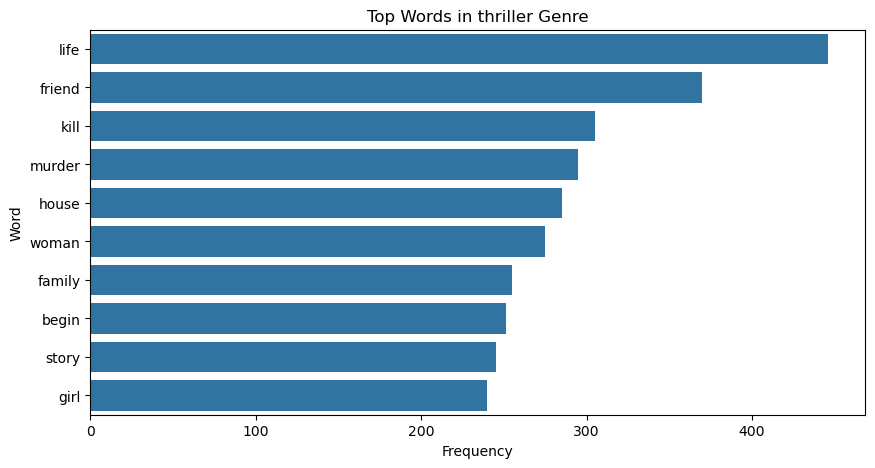

In [181]:
from collections import Counter
import seaborn as sns

for genre in genres:
    tokens = df[df['Genre'] == genre]['description_tokens'].explode()
    word_counts = Counter(tokens)
    common = word_counts.most_common(10)
    
    words, freqs = zip(*common)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title(f'Top Words in {genre} Genre')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()


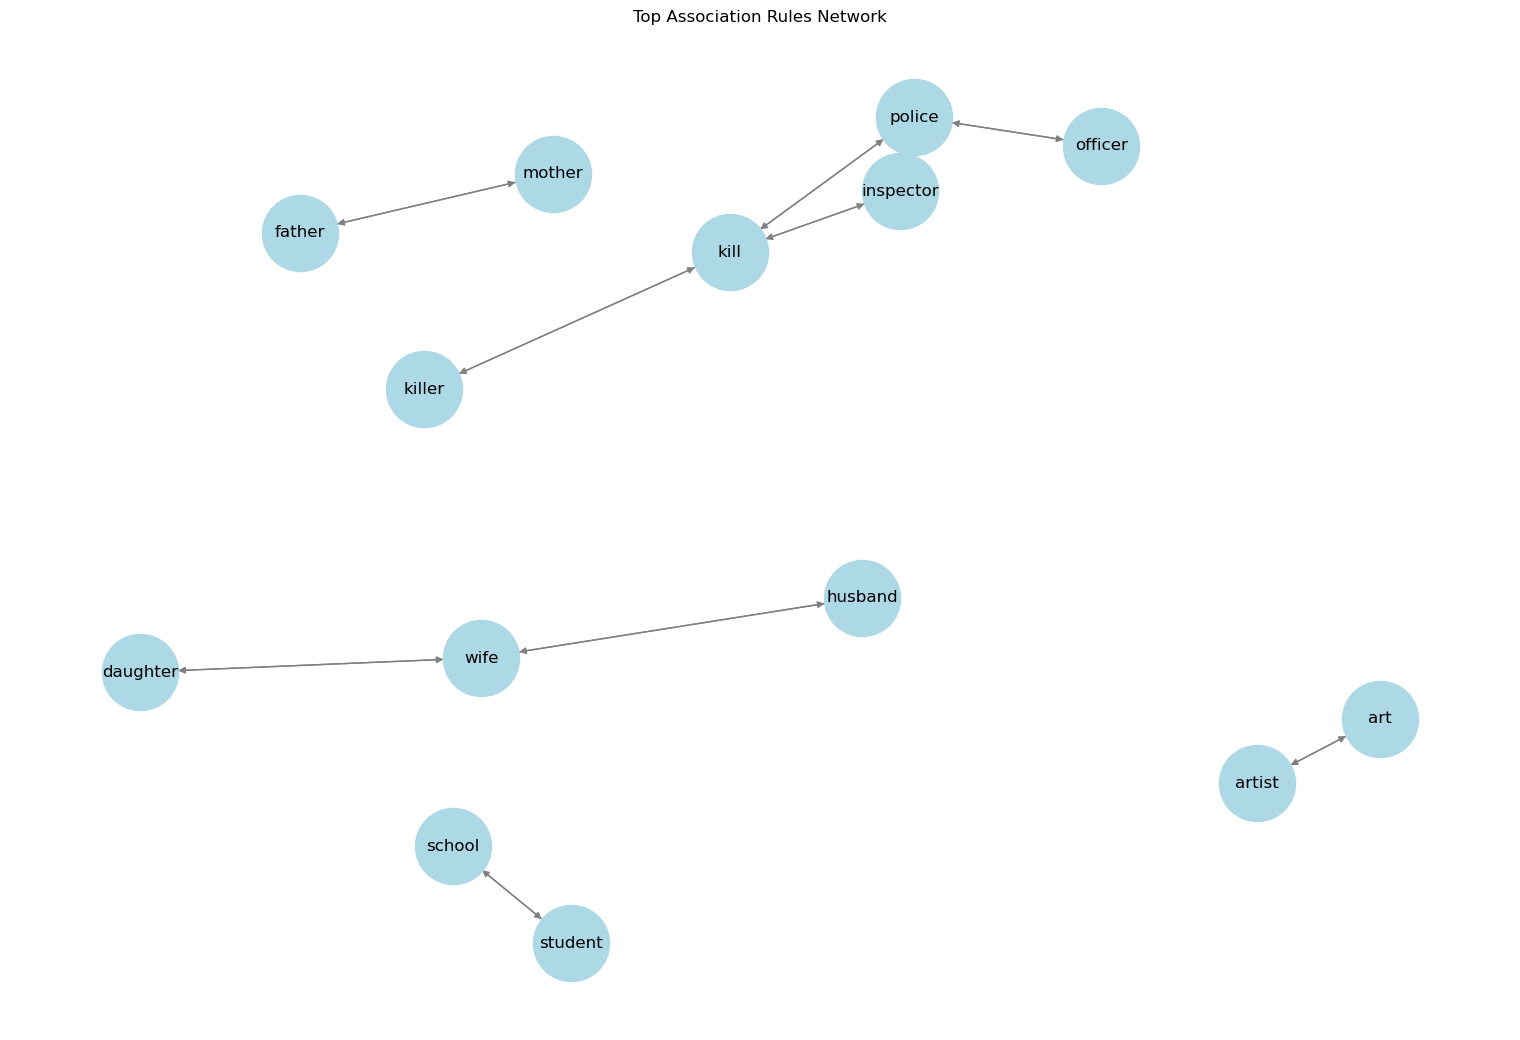

In [182]:
import networkx as nx

# Example: Use top 20 ARM rules (you can filter by lift or confidence)
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3.0)
rules = rules.sort_values('lift', ascending=False).head(20)

G = nx.DiGraph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
        edge_color='gray', font_size=12, arrows=True)
plt.title('Top Association Rules Network')
plt.show()


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


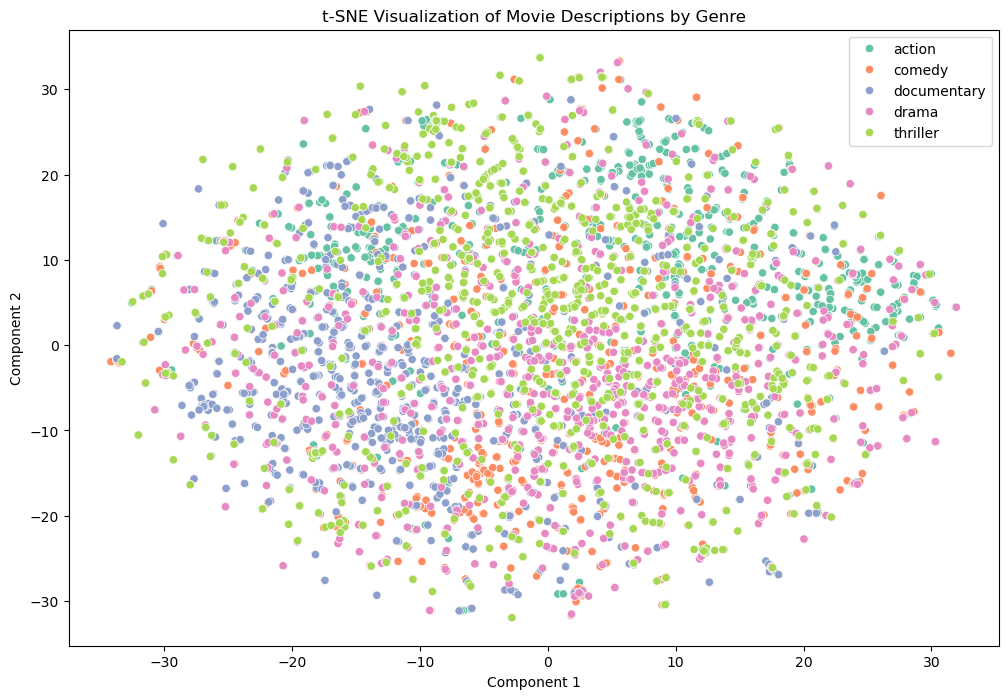

In [183]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce TF-IDF vectors to 2D
X_reduced = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(description_tfidf.toarray())

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=df['Genre'], palette='Set2')
plt.title('t-SNE Visualization of Movie Descriptions by Genre')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


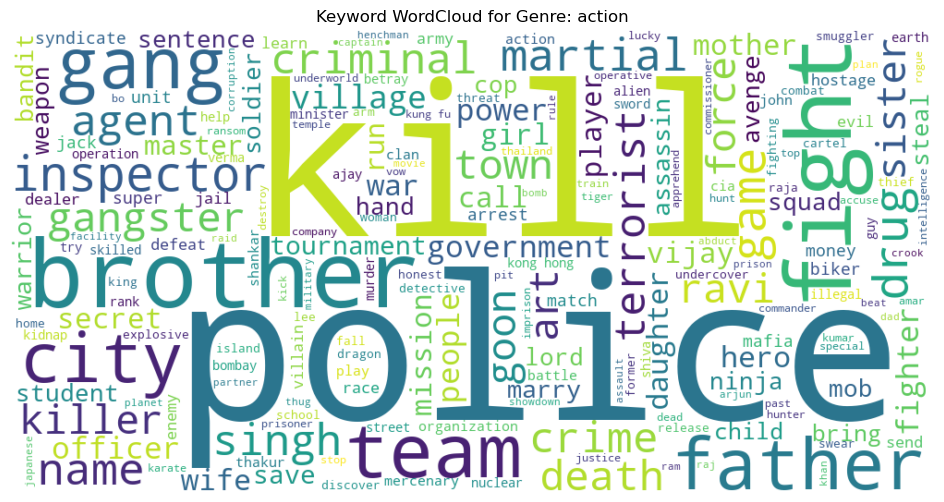

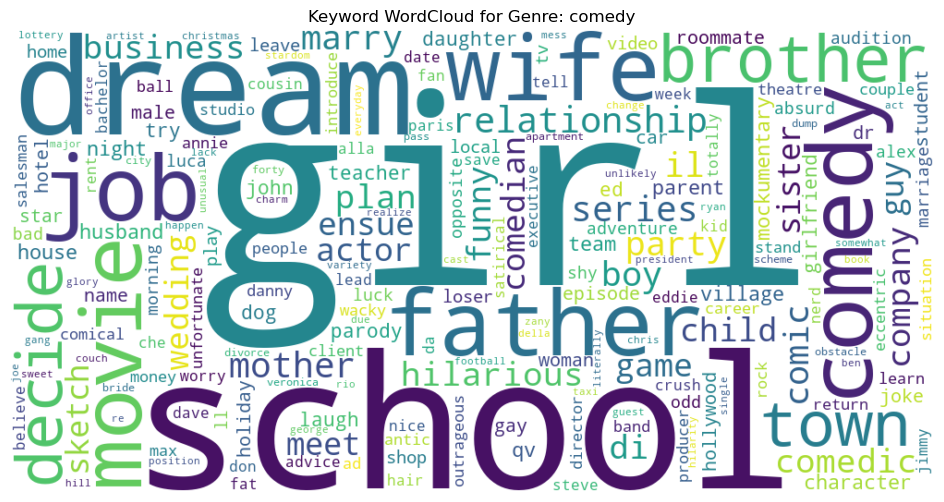

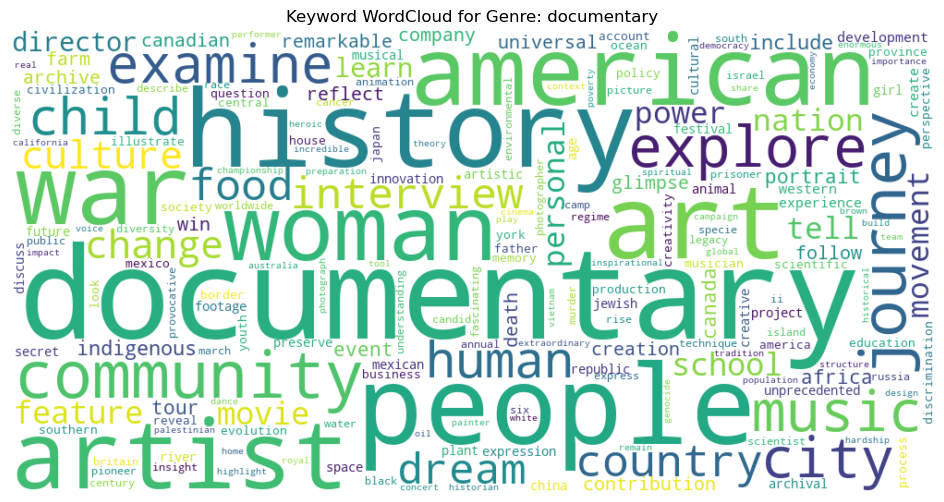

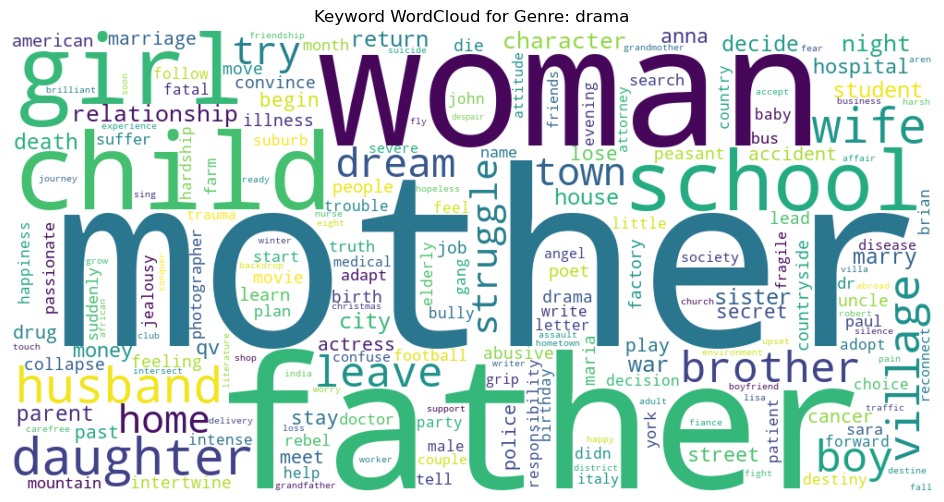

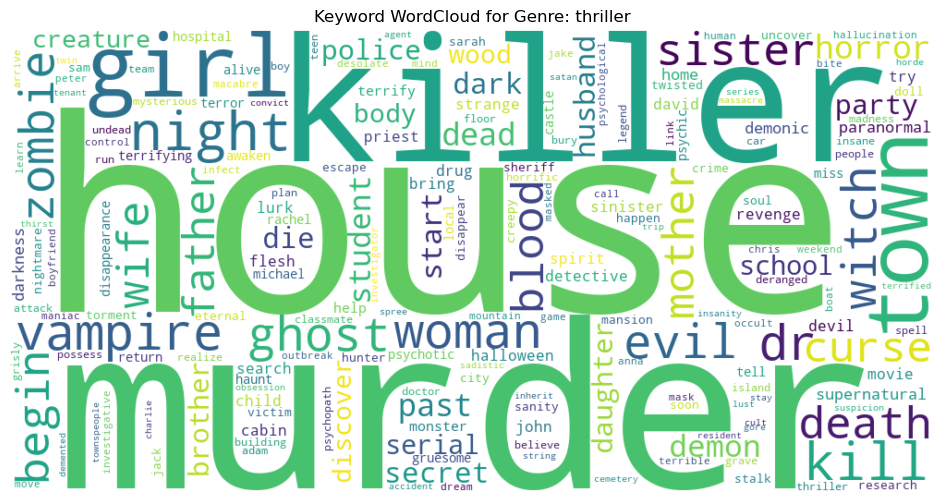

In [207]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

genres = df['Genre'].unique()

for genre in genres:
    # Extract keywords dictionaries for the genre and flatten keys to a list
    keyword_lists = df[df['Genre'] == genre]['keywords'].tolist()
    
    # Flatten list of dict keys into one list of keywords
    keywords = []
    for kw_dict in keyword_lists:
        keywords.extend(kw_dict.keys())
    
    # Join all keywords into one big string
    text = ' '.join(keywords)
    
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Keyword WordCloud for Genre: {genre}')
    plt.show()


# DONT LOOK BELOW

# BOW MODELLING

In [184]:
X = description_bow_matrix
y = df["Genre"].values

In [185]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'train_test_split' is not defined

# BEFORE TRAINING

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔵 Logistic Regression Report")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))
f1_log = f1_score(y_test, y_pred_log, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_log:.4f}")

🔵 Logistic Regression Report
              precision    recall  f1-score   support

      action       0.73      0.70      0.71       316
      comedy       0.59      0.59      0.59       309
 documentary       0.73      0.80      0.76       284
       drama       0.55      0.56      0.56       301
    thriller       0.73      0.69      0.71       290

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.66      1500

🎯 Weighted F1 Score: 0.6650


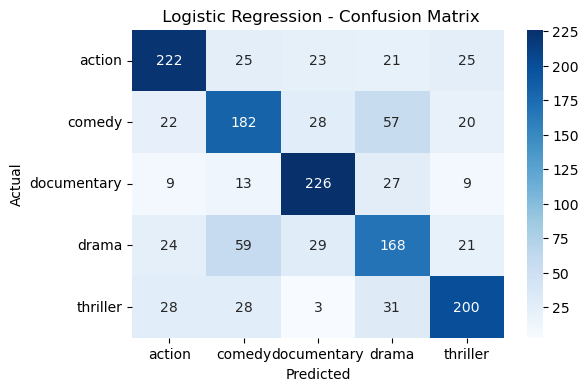

In [ ]:
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🟢 Random Forest Report")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_rf:.4f}")


🟢 Random Forest Report
              precision    recall  f1-score   support

      action       0.63      0.67      0.65       316
      comedy       0.67      0.48      0.56       309
 documentary       0.70      0.85      0.77       284
       drama       0.52      0.58      0.55       301
    thriller       0.67      0.60      0.64       290

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.63      1500
weighted avg       0.64      0.64      0.63      1500

🎯 Weighted F1 Score: 0.6313


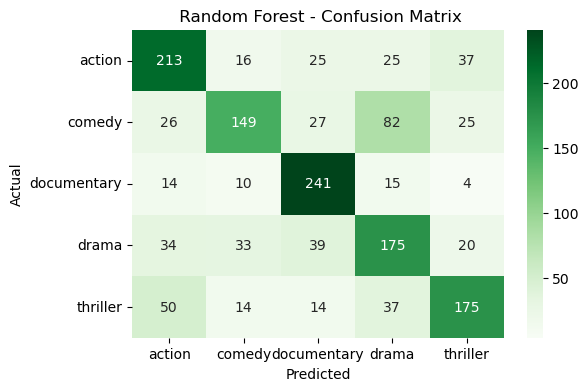

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("🟡 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_nb:.4f}")

🟡 Naive Bayes Report
              precision    recall  f1-score   support

      action       0.75      0.69      0.72       316
      comedy       0.66      0.59      0.63       309
 documentary       0.71      0.86      0.78       284
       drama       0.54      0.54      0.54       301
    thriller       0.74      0.73      0.73       290

    accuracy                           0.68      1500
   macro avg       0.68      0.68      0.68      1500
weighted avg       0.68      0.68      0.68      1500

🎯 Weighted F1 Score: 0.6779


c:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


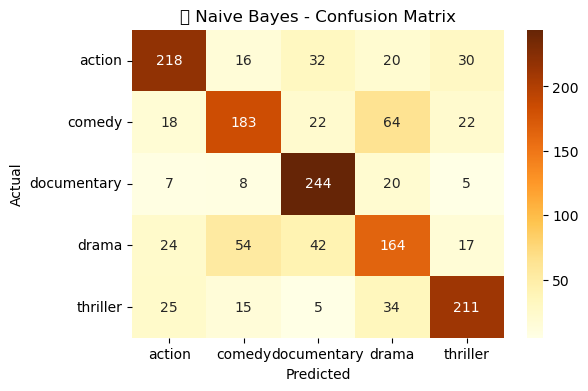

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("🟡 Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AFTER TRAINING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Feature selection
selector = SelectKBest(chi2, k=3900)  # you can change k=2000/4000 as needed
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Plotting function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.72      0.73       300
      comedy       0.65      0.68      0.67       300
 documentary       0.80      0.80      0.80       300
       drama       0.59      0.58      0.59       300
    thriller       0.71      0.70      0.71       300

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Weighted F1 Score: 0.6994


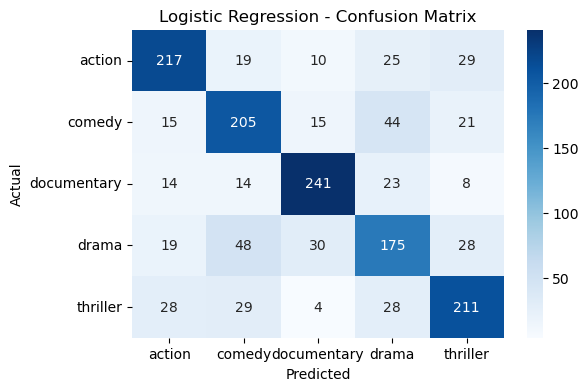

In [ ]:
print("🔵 Logistic Regression")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='f1_weighted', cv=5)
grid_lr.fit(X_train_sel, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.68      0.66       300
      comedy       0.65      0.50      0.57       300
 documentary       0.72      0.78      0.75       300
       drama       0.53      0.56      0.55       300
    thriller       0.67      0.71      0.69       300

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.64      1500
weighted avg       0.65      0.65      0.64      1500

🎯 Weighted F1 Score: 0.6429


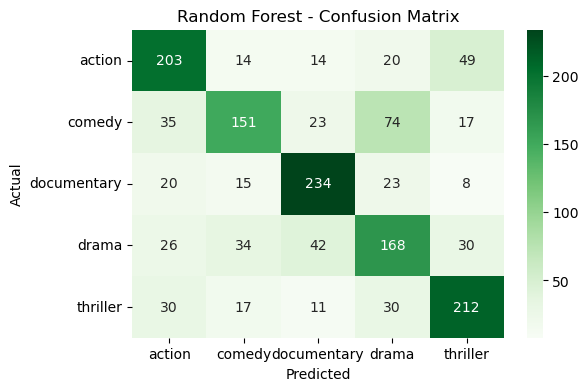

In [ ]:
# --- RANDOM FOREST ---

print("🟢 Random Forest")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='f1_weighted', cv=5)
grid_rf.fit(X_train_sel, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_sel)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)


🟡 Naive Bayes
              precision    recall  f1-score   support

      action       0.73      0.68      0.70       300
      comedy       0.67      0.64      0.66       300
 documentary       0.73      0.82      0.77       300
       drama       0.58      0.58      0.58       300
    thriller       0.72      0.72      0.72       300

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500

🎯 Weighted F1 Score: 0.6868


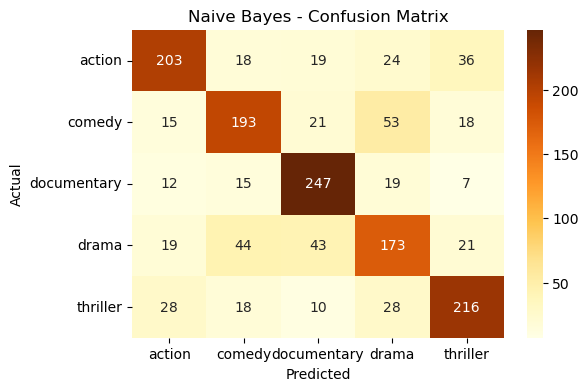

In [ ]:
# --- NAIVE BAYES ---

print("🟡 Naive Bayes")

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, scoring='f1_weighted', cv=5)
grid_nb.fit(X_train_sel, y_train)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_sel)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "YlOrBr", label_encoder.classes_)


In [ ]:
print("\n📊 Model F1 Score Comparison")
print(f"Logistic Regression: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"Random Forest     : {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Naive Bayes       : {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")



📊 Model F1 Score Comparison
Logistic Regression: 0.6994
Random Forest     : 0.6429
Naive Bayes       : 0.6868


# TFIDF MODELLING

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.16, max_features=5000)
tfidf_X = vectorizer.fit_transform(description_string)
tfidf_X_vectorized = tfidf_X.toarray()

In [ ]:
print(tfidf_X_vectorized.max())

1.0


In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.76      0.75       409
      comedy       0.67      0.65      0.66       418
 documentary       0.76      0.81      0.78       402
       drama       0.57      0.56      0.57       388
    thriller       0.74      0.71      0.72       383

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

🎯 Weighted F1 Score: 0.6976


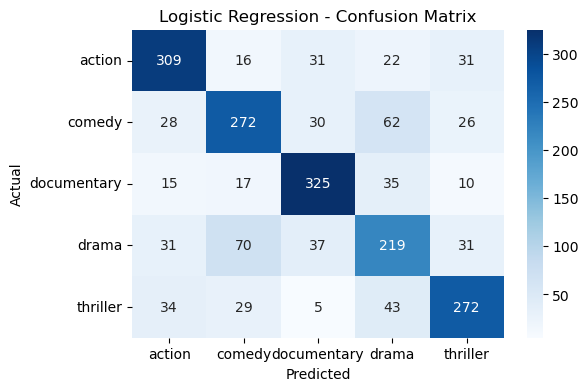

In [ ]:
print("🔵 Logistic Regression")

model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)


🟣 Naive Bayes
              precision    recall  f1-score   support

      action       0.72      0.74      0.73       409
      comedy       0.75      0.52      0.62       418
 documentary       0.75      0.81      0.78       402
       drama       0.56      0.62      0.59       388
    thriller       0.69      0.75      0.72       383

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

🎯 Weighted F1 Score: 0.6861


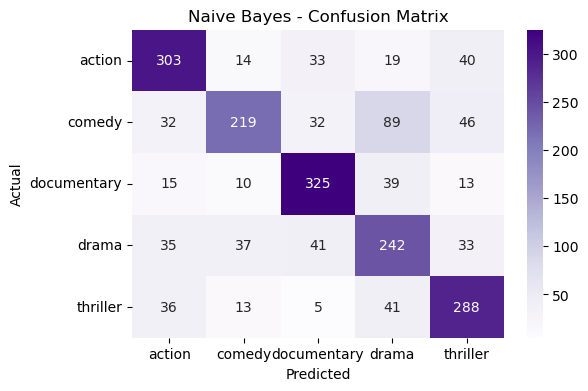

In [ ]:
print("🟣 Naive Bayes")

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "Purples", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.69      0.67       409
      comedy       0.64      0.46      0.54       418
 documentary       0.72      0.78      0.75       402
       drama       0.47      0.54      0.51       388
    thriller       0.67      0.66      0.67       383

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

🎯 Weighted F1 Score: 0.6254


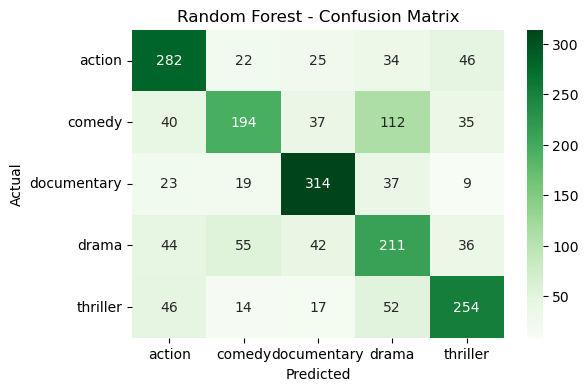

In [ ]:
print("🟢 Random Forest")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)

# AFTER TRAINING TFIDF

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)


selector = SelectKBest(chi2, k=3900)
X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
X_test_sel = selector.transform(X_test_tfidf)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'solver': ['liblinear', 'lbfgs'],   # Optimization solver
    'penalty': ['l2']                   # Regularization type (lbfgs only supports 'l2')
}

# Create the model
lr = LogisticRegression(max_iter=1000)

# Grid search using weighted F1 score and 5-fold CV
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, 
                       scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

# Fit the model using selected features (after SelectKBest)
grid_lr.fit(X_train_sel, y_train)

# Best model and predictions
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

# Results
print("🔵 Best Logistic Regression Parameters:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Best Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
🔵 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

      action       0.75      0.72      0.74       316
      comedy       0.67      0.66      0.66       309
 documentary       0.74      0.83      0.79       284
       drama       0.61      0.60      0.60       301
    thriller       0.75      0.72      0.73       290

    accuracy                           0.70      1500
   macro avg       0.70      0.71      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Best Weighted F1 Score: 0.7038
